# Minería de Texto

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.pipeline import Pipeline
import nltk
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import importlib
import funciones
importlib.reload(funciones)
from matplotlib import pyplot as plt


### 1. Preprocesamiento del texto

In [2]:
nltk.data.path.append('/home/tux/nltk_data')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /home/tux/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tux/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/tux/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tux/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/tux/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tux/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [3]:
# url = 'https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv'
df = pd.read_csv('data/sms.tsv', sep='\t', names=['label', 'message'])
print(df.head())

  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [4]:
df['cleaned'] = funciones.preprocess(df['message'])
print(df['cleaned'].head())

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: cleaned, dtype: object


In [5]:
df['lemmas'] = funciones.lemmatize(df['cleaned'])
df['lemmas'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, go, usf, life, around, though]
Name: lemmas, dtype: object

In [6]:
display(df)

,label,message,cleaned,lemmas
0,ham,"Go until jurong point, crazy.. Available only ...","[go, jurong, point, crazy, available, bugis, n...","[go, jurong, point, crazy, available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,"[ok, lar, joking, wif, u, oni]","[ok, lar, joking, wif, u, oni]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[free, entry, 2, wkly, comp, win, fa, cup, fin...","[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,ham,U dun say so early hor... U c already then say...,"[u, dun, say, early, hor, u, c, already, say]","[u, dun, say, early, hor, u, c, already, say]"
4,ham,"Nah I don't think he goes to usf, he lives aro...","[nah, dont, think, goes, usf, lives, around, t...","[nah, dont, think, go, usf, life, around, though]"
...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,"[2nd, time, tried, 2, contact, u, u, £750, pou...","[2nd, time, try, 2, contact, u, u, £750, pound..."
5568,ham,Will ü b going to esplanade fr home?,"[ü, b, going, esplanade, fr, home]","[ü, b, go, esplanade, fr, home]"
5569,ham,"Pity, * was in mood for that. So...any other s...","[pity, mood, soany, suggestions]","[pity, mood, soany, suggestion]"
5570,ham,The guy did some bitching but I acted like i'd...,"[guy, bitching, acted, like, id, interested, b...","[guy, bitch, act, like, id, interested, buying..."


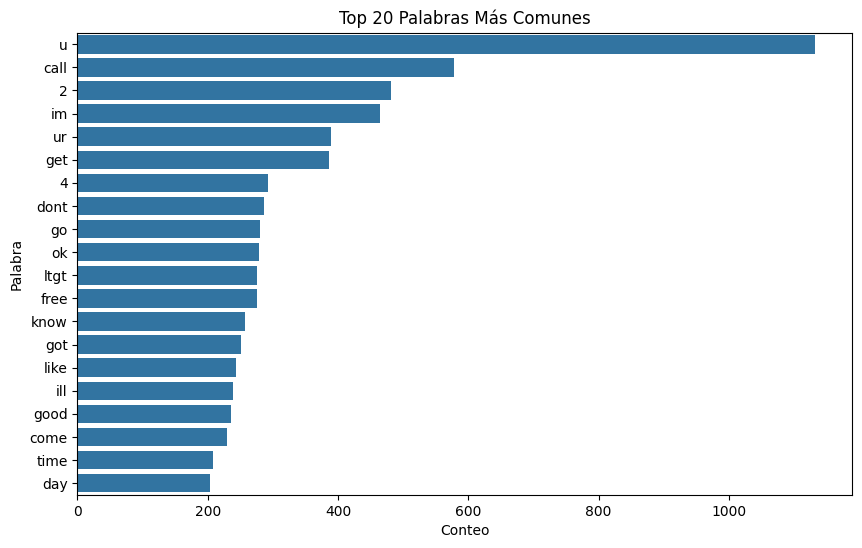

In [7]:
funciones.common_words(df['cleaned'], 20)

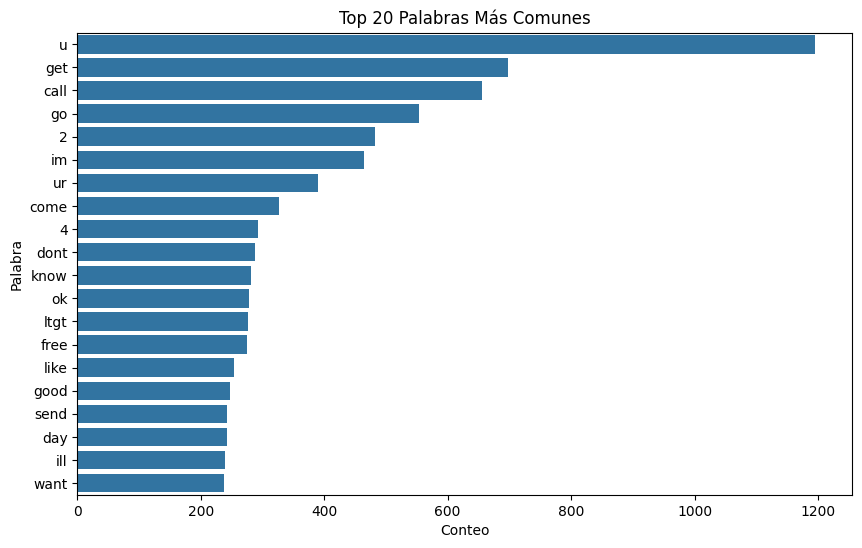

In [8]:
funciones.common_words(df['lemmas'], 20)

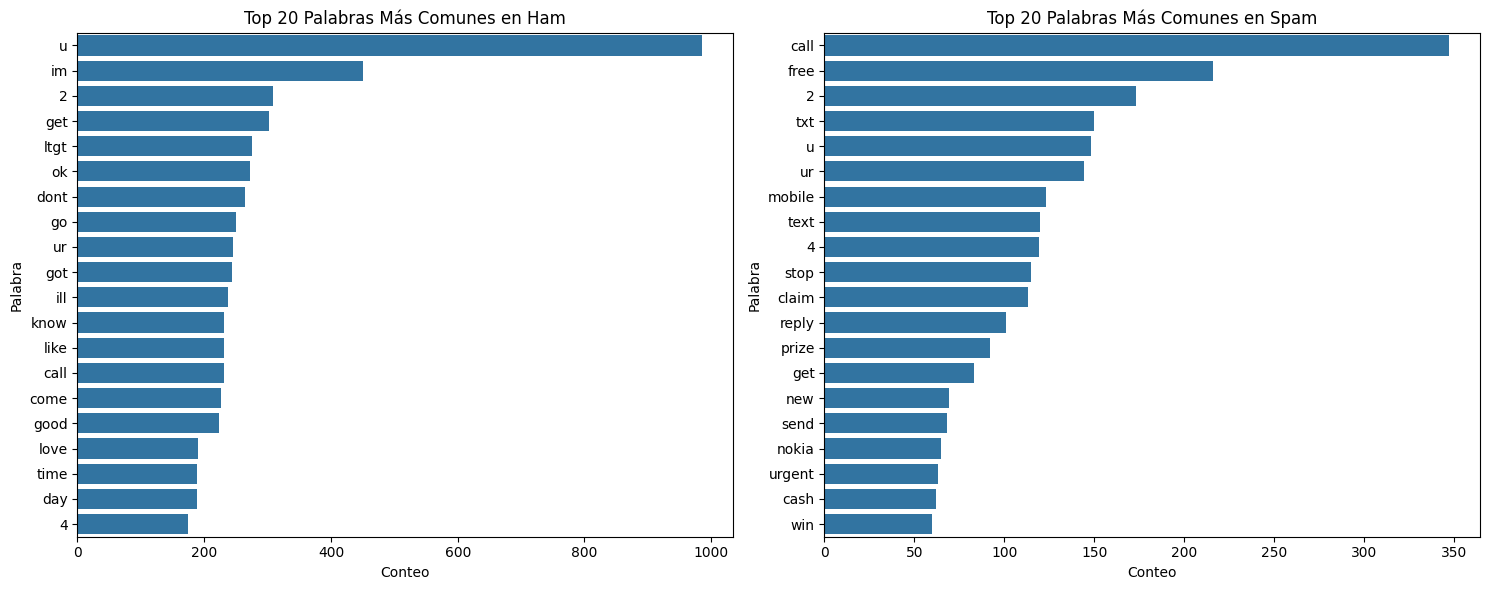

In [9]:
funciones.common_words_by_label(df, 'cleaned', 20)

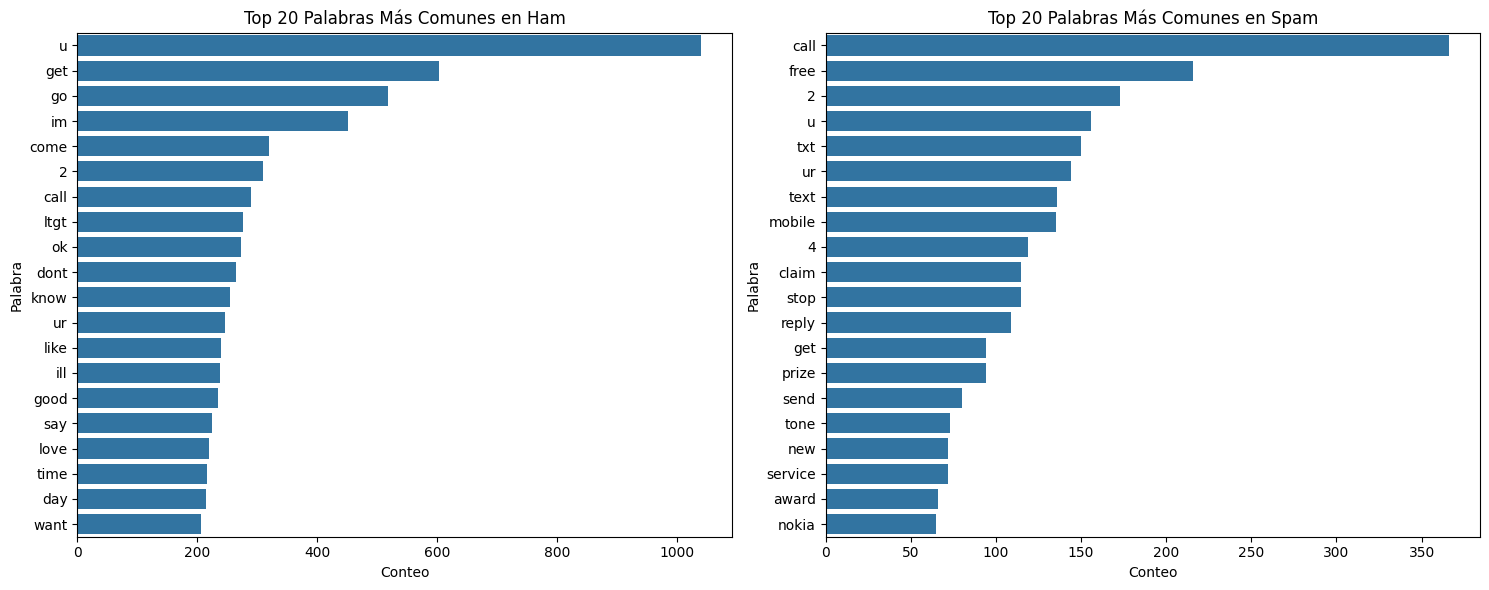

In [10]:
funciones.common_words_by_label(df, 'lemmas', 20)

### 2. Vectorización

In [11]:
df['lemmas_str'] = df['lemmas'].apply(lambda tokens: ' '.join(tokens))

vectorizer_eda = TfidfVectorizer(
    max_df=0.90,
    min_df=0.02,
    ngram_range=(1, 1),
    stop_words=stopwords.words('english')
)

In [12]:
tfidf_matrix = vectorizer_eda.fit_transform(df['lemmas_str'])
feature_names = vectorizer_eda.get_feature_names_out()

tfidf_sums = tfidf_matrix.sum(axis=0).A1  # convert from matrix to array
tfidf_scores = list(zip(feature_names, tfidf_sums))
sorted_terms = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)

top20 = sorted_terms[:10]
formatted = ", ".join(
    f"({term}, {score:.2f})"
    for term, score in top20
)
print(formatted)

(get, 353.54), (call, 339.54), (go, 291.54), (im, 253.20), (come, 189.45), (ur, 187.47), (ok, 183.01), (know, 156.86), (dont, 154.87), (ltgt, 150.22)


## 3 Modelado y evaluación

In [13]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
print(df['label_num'].value_counts())

label_num
0    4825
1     747
Name: count, dtype: int64


In [14]:
X = df['lemmas_str']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [15]:
vectorizer = TfidfVectorizer(
    max_df=0.90,
    min_df=0.02,
    ngram_range=(1, 1),
    stop_words=stopwords.words('english')
)

In [16]:
# Definimos los pipelines
pipe_lr = Pipeline([
    ('tfidf', vectorizer),
    ('clf', LogisticRegression(max_iter=1000))
])

In [17]:
scoring = {'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1'}

param_grid_lr = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.85, 0.90, 0.95],
    'tfidf__min_df': [0.01, 0.02, 0.05],
    'clf__C': [0.1, 1, 10, 100],
    'clf__solver': ['liblinear', 'saga', 'lbfgs'],
    'clf__class_weight': [None, 'balanced']
}

grid_search_lr = GridSearchCV(pipe_lr, 
                              param_grid_lr, 
                              cv=3, 
                              scoring=scoring, 
                              refit='recall',
                              n_jobs=-1)

grid_search_lr.fit(X_train, y_train)

print("Mejores parámetros:", grid_search_lr.best_params_)
print("Mejor score CV:", grid_search_lr.best_score_)
print("Recall en test:", grid_search_lr.score(X_test, y_test))



/home/tux/text-mining/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tux/text-mining/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tux/text-mining/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tux/text-mining/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tux/text-mining/env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/tux/text-mining/env/lib/python3.10/site-pack

Mejores parámetros: {'clf__C': 1, 'clf__class_weight': 'balanced', 'clf__solver': 'liblinear', 'tfidf__max_df': 0.85, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 1)}
Mejor score CV: 0.8837728026533996
Recall en test: 0.896551724137931


In [18]:
y_proba = grid_search_lr.predict_proba(X_test)[:, 1]
umbral = 0.65  # ← Ajusta este valor entre 0.2 y 0.5
y_pred_umbral = (y_proba >= umbral).astype(int)

print(classification_report(y_test, y_pred_umbral))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       970
           1       0.79      0.87      0.83       145

    accuracy                           0.95      1115
   macro avg       0.88      0.92      0.90      1115
weighted avg       0.96      0.95      0.95      1115



In [19]:
# Predicciones
y_pred = grid_search_lr.predict(X_test)

# Informe de clasificación
print(classification_report(y_test, y_pred, target_names=['Ham (0)', 'Spam (1)']))

              precision    recall  f1-score   support

     Ham (0)       0.98      0.95      0.97       970
    Spam (1)       0.72      0.90      0.80       145

    accuracy                           0.94      1115
   macro avg       0.85      0.92      0.88      1115
weighted avg       0.95      0.94      0.94      1115



In [20]:
# scoring = {'precision': 'precision',
#            'recall': 'recall',
#            'f1': 'f1'}

# param_grid_lr = {
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
#     'tfidf__max_df': [0.85, 0.90, 0.95],
#     'tfidf__min_df': [0.01, 0.02, 0.05],
#     'clf__C': [0.1, 1, 10, 100],
#     'clf__solver': ['liblinear', 'saga', 'lbfgs'],
#     'clf__class_weight': [None, 'balanced']
# }

# grid_search_recall = GridSearchCV(pipe_lr, 
#                               param_grid_lr, 
#                               cv=3, 
#                               scoring=scoring, 
#                               refit='recall',
#                               n_jobs=-1)

# grid_search_recall.fit(X_train, y_train)

# print("Mejores parámetros:", grid_search_recall.best_params_)
# print("Mejor score CV:", grid_search_recall.best_score_)
# print("Recall en test:", grid_search_recall.score(X_test, y_test))

In [21]:
# scoring = {'precision': 'precision',
#            'recall': 'recall',
#            'f1': 'f1'}

# param_grid_lr = {
#     'tfidf__ngram_range': [(1, 1), (1, 2)],
#     'tfidf__max_df': [0.85, 0.90, 0.95],
#     'tfidf__min_df': [0.01, 0.02, 0.05],
#     'clf__C': [0.1, 1, 10, 100],
#     'clf__solver': ['liblinear', 'saga', 'lbfgs'],
#     'clf__class_weight': [None, 'balanced']
# }

# grid_search_f1 = GridSearchCV(pipe_lr, 
#                               param_grid_lr, 
#                               cv=3, 
#                               scoring=scoring, 
#                               refit='f1',
#                               n_jobs=-1)

# grid_search_f1.fit(X_train, y_train)

# print("Mejores parámetros:", grid_search_f1.best_params_)
# print("Mejor score CV:", grid_search_f1.best_score_)
# print("F1 en test:", grid_search_f1.score(X_test, y_test))

In [22]:
# # Modelo optimizado por recall
# y_pred_recall = grid_search_recall.predict(X_test)

# # Modelo optimizado por f1
# y_pred_f1 = grid_search_f1.predict(X_test)

# print("Modelo por recall:")
# print(classification_report(y_test, y_pred_recall))

# print("\nModelo por f1:")
# print(classification_report(y_test, y_pred_f1))

In [23]:
#Guardamos el modelo
joblib.dump(grid_search_lr.best_estimator_, 'logistic_regression.pkl')

['logistic_regression.pkl']

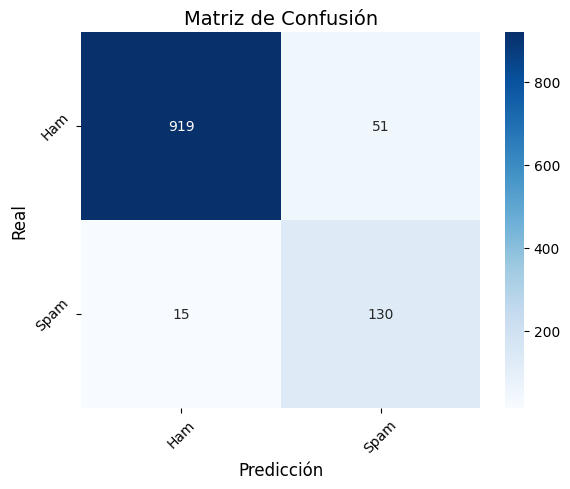

In [28]:
# Crear un mapa de calor con Seaborn
# Calcular la matriz de confusión

funciones.confusion_matrix_plot(y_test, y_pred)


In [25]:
pipe_mnb = Pipeline([
    ('tfidf', vectorizer),
    ('clf', MultinomialNB())
])

In [29]:
param_grid_mnb = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.85, 0.90, 0.95],
    'tfidf__min_df': [0.01, 0.02, 0.05],
    'clf__alpha': [0.5, 1, 1.1, 1.5],
    'clf__fit_prior': [True, False]
}

grid_search_mnb = GridSearchCV(pipe_mnb, param_grid_mnb, cv=3, scoring='recall', n_jobs=-1)
grid_search_mnb.fit(X_train, y_train)

print("Mejores parámetros:", grid_search_mnb.best_params_)
print("Recall en test:", grid_search_mnb.score(X_test, y_test))

#Guardamos el modelo
joblib.dump(grid_search_mnb.best_estimator_, 'multinomial_nb.pkl')

Mejores parámetros: {'clf__alpha': 1, 'clf__fit_prior': False, 'tfidf__max_df': 0.85, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 1)}
Recall en test: 0.9103448275862069


['multinomial_nb.pkl']

In [30]:
# Predicciones
y_pred = grid_search_lr.predict(X_test)

# Informe de clasificación
print(classification_report(y_test, y_pred, target_names=['Ham (0)', 'Spam (1)']))

              precision    recall  f1-score   support

     Ham (0)       0.97      0.98      0.98       970
    Spam (1)       0.87      0.81      0.84       145

    accuracy                           0.96      1115
   macro avg       0.92      0.89      0.91      1115
weighted avg       0.96      0.96      0.96      1115



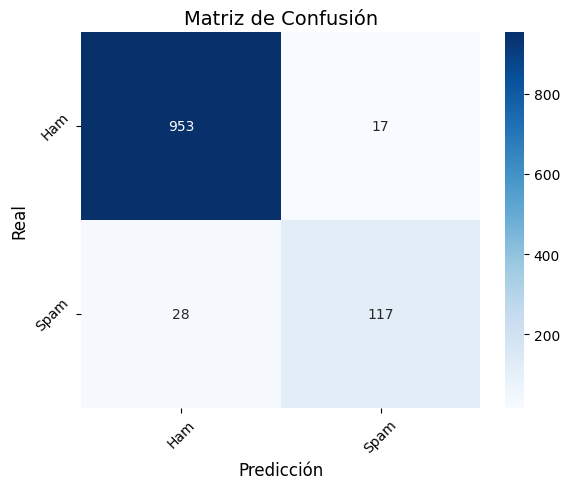

In [31]:
funciones.confusion_matrix_plot(y_test, y_pred)